# **AI Techniques and Tools**

# **Final Project : Apply Data Science Pipeline & Machine Learning**

*   Student : Yahiaoui Amira
*   Speciality : Computer Science
*   Objective : applying machine learning and natural language processing (NLP) to detect toxic online comments. By training on a labeled dataset ( wikipedia comments), the model classifies comments into multiple categories such as insult, hate speech, or threat.

Abstract : This project focuses on developing an automated system to detect and classify toxic comments in online text. It addresses multiple categories of toxicity, including toxic, severe toxic, obscene, threat, insult, and identity hate, using a multi-label classification approach. The system leverages TF-IDF for feature extraction and Logistic Regression models trained independently for each label. To handle class imbalance, oversampling and class weighting techniques are applied, and per-label threshold tuning is used to optimize the F1-score for better prediction performance. The model is evaluated using metrics such as ROC-AUC, F1-score, and confusion matrices, demonstrating its effectiveness in identifying harmful content. This approach provides a foundation for automated content moderation and can be further extended to more advanced models or larger datasets.

## **1- Libraries imports**

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **2- Loading and reading the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [ ]:
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 3- Data preprocessing and cleaning

# 3-1- Statistical overview

In [ ]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


# **3-2- Handle missing values**

In [ ]:
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


there are no messing values in this dataset

In [ ]:
df.duplicated().sum()

np.int64(0)

# **3-3-Text Preprocessing**

In [ ]:
def preprocess_text(text):
    text = str(text).lower()

    # Replace IP addresses
    text = re.sub(r'\d{1,3}(\.\d{1,3}){3}', 'ipaddress', text)

    # Replace URLs
    text = re.sub(r'http[s]?://\S+', 'httpaddr', text)

    # Replace user mentions
    text = re.sub(r'@[\w\-]+', 'usermention', text)

    # Replace newlines and tabs
    text = text.replace('\n', ' ').replace('\t', ' ')

    # Expand common contractions
    contractions = {
        "can't": "cannot",
        "don't": "do not",
        "didn't": "did not",
        "aren't": "are not"
    }
    for c, e in contractions.items():
        text = text.replace(c, e)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
df['clean_text'] = df['comment_text'].apply(preprocess_text)


# **4-Exploratory Data Analysis**

In [ ]:
print(df.iloc[:, 2:].dtypes)


toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
clean_text       object
dtype: object


In [ ]:
x = df.select_dtypes(include=[np.number]).sum()
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


In [ ]:
rowsums = df.select_dtypes(include=[np.number]).sum(axis=1)
rowsums


,0
0,0
1,0
2,0
3,0
4,0
...,...
159566,0
159567,0
159568,0
159569,0


In [ ]:
df = df.drop(columns=['id'], axis=1)
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww! he matches this background colour i'm s...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man, i'm really not trying to edit war. it..."
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" more i cannot make any real suggestions on i..."
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you, sir, are my hero. any chance you remember..."


# 4-1-Label Distribution

In [ ]:
labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

Total number of comments: 159571
Total number of comments without labels: 143346
Total labels: 35098


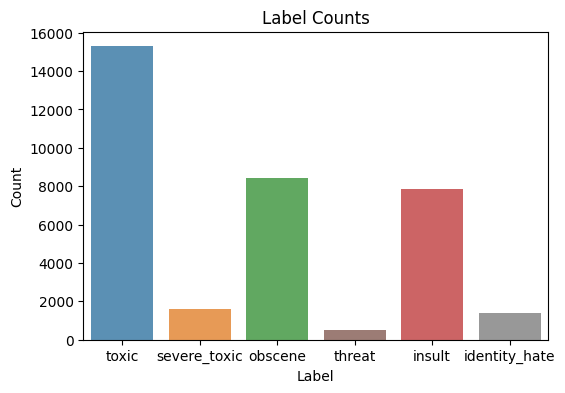

In [ ]:
no_label_count = 0

for i, count in rowsums.items():
    if count==0:
        no_label_count += 1

print('Total number of comments:', len(df))
print('Total number of comments without labels:', no_label_count)
print('Total labels:', x.sum())
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Label Counts')
plt.ylabel('Count')
plt.xlabel('Label')

plt.show()

Positive examples per label:
toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64


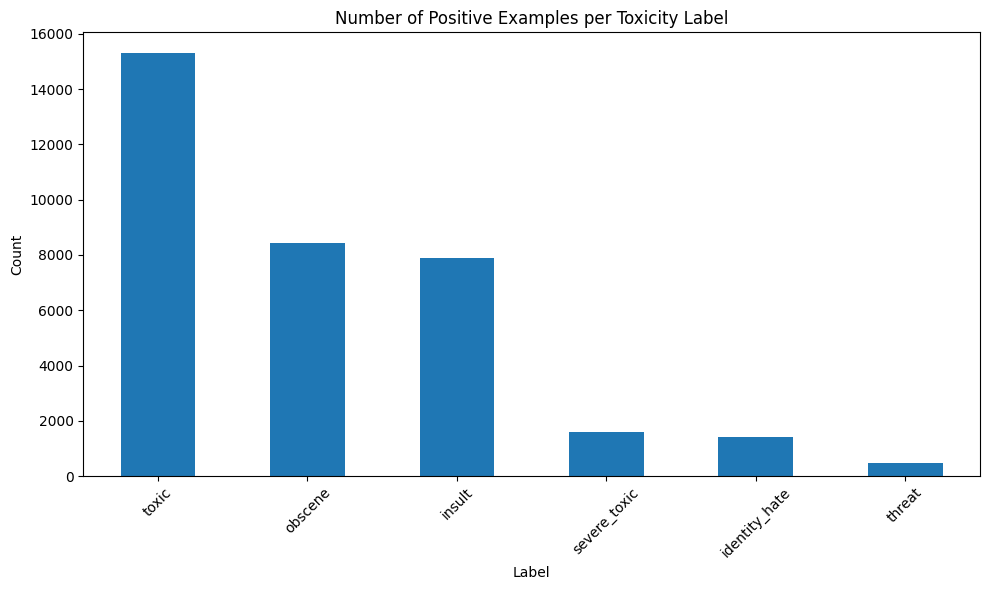

In [ ]:
print("Positive examples per label:")
print(df[labels].sum().sort_values(ascending=False))

df[labels].sum().sort_values(ascending=False).plot(
    kind='bar', figsize=(10, 6)
)
plt.title('Number of Positive Examples per Toxicity Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4-2- Comment Length Analysis

count    159571.000000
mean        388.114538
std         582.931299
min           6.000000
25%          93.000000
50%         202.000000
75%         429.000000
max        5072.000000
Name: length, dtype: float64
any_toxic
0    398.240342
1    298.654237
Name: length, dtype: float64


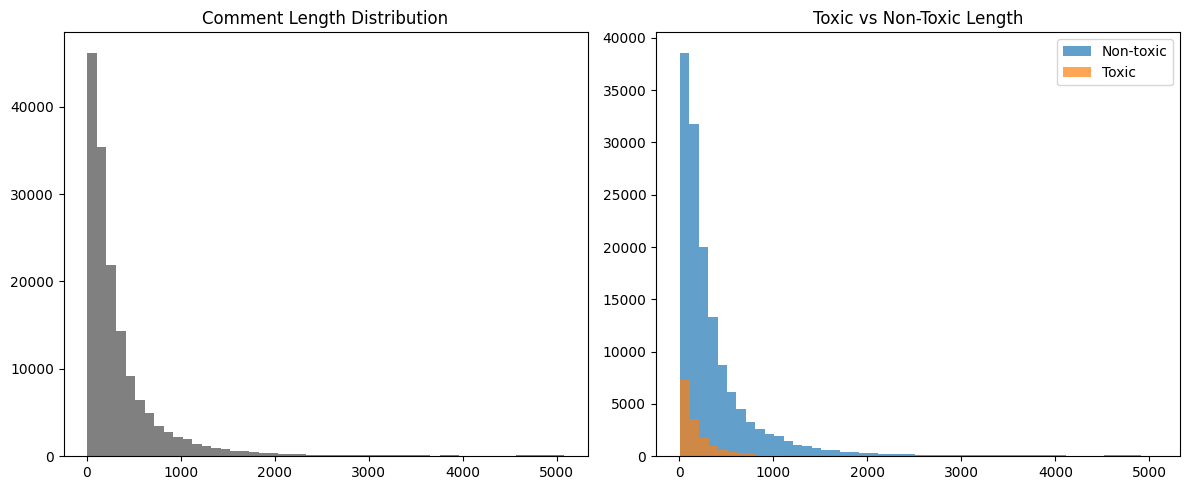

In [ ]:
df['length'] = df['clean_text'].str.len()
df['any_toxic'] = df[labels].max(axis=1)

print(df['length'].describe())
print(df.groupby('any_toxic')['length'].mean())
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['length'], bins=50, color='gray')
plt.title('Comment Length Distribution')

plt.subplot(1, 2, 2)
plt.hist(df[df['any_toxic'] == 0]['length'], bins=50, label='Non-toxic', alpha=0.7)
plt.hist(df[df['any_toxic'] == 1]['length'], bins=50, label='Toxic', alpha=0.7)
plt.legend()
plt.title('Toxic vs Non-Toxic Length')

plt.tight_layout()
plt.show()


# 4-3-Label Correlation and Overlap

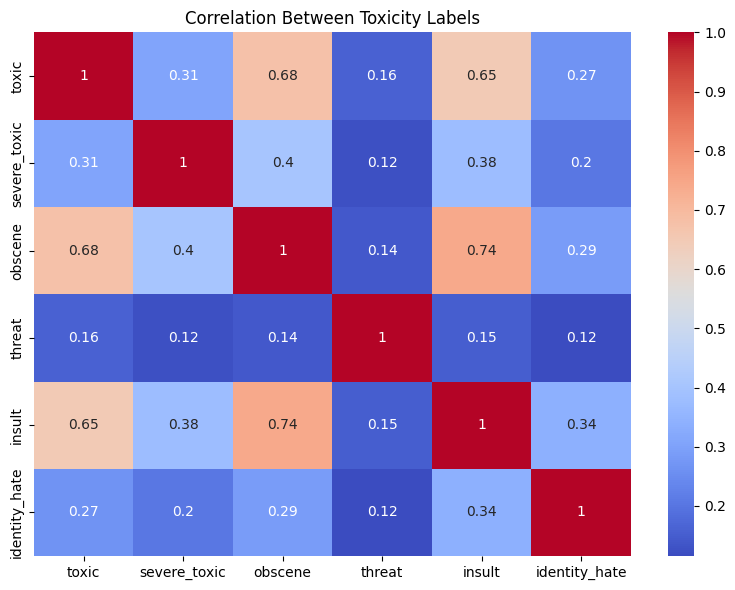

0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64


In [ ]:
correlation_matrix = df[labels].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Toxicity Labels')
plt.tight_layout()
plt.show()
overlap_counts = df[labels].sum(axis=1).value_counts().sort_index()
print(overlap_counts)



# 4-4-Word Cloud Visualization

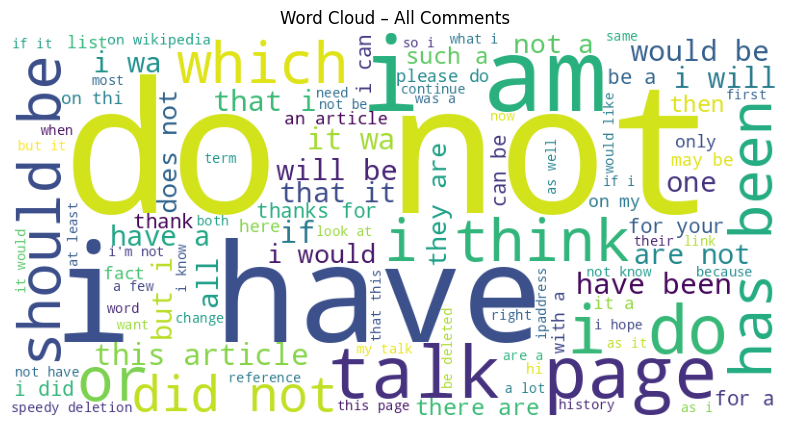

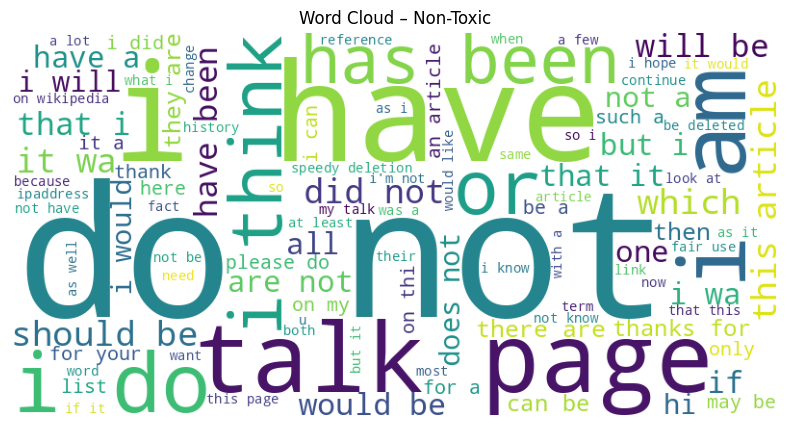

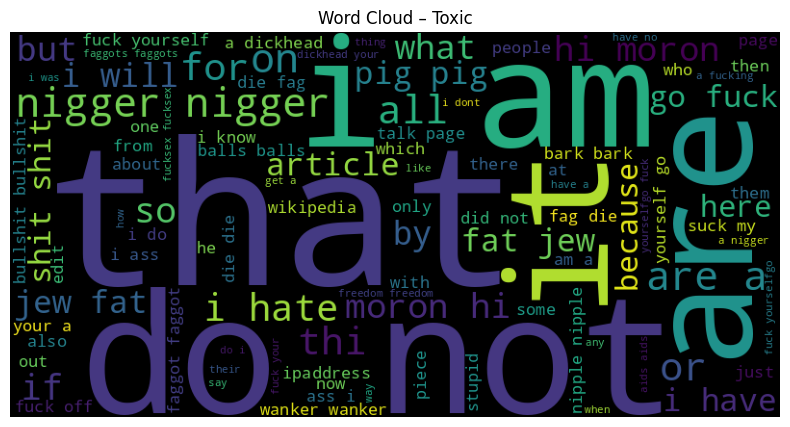

In [ ]:
def generate_wordcloud(text_series, title, background_color='white'):
    text = ' '.join(text_series)
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color=background_color,
        max_words=100,
        stopwords={'the', 'and', 'to', 'of', 'in', 'is', 'you'}
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.show()
generate_wordcloud(df['clean_text'], 'Word Cloud – All Comments')
generate_wordcloud(df[df['any_toxic'] == 0]['clean_text'], 'Word Cloud – Non-Toxic')
generate_wordcloud(df[df['any_toxic'] == 1]['clean_text'], 'Word Cloud – Toxic', background_color='black')


# **5- Logistic Regression-Based Multi-Label Classification**

In [ ]:
df = pd.read_csv('train.csv')

labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

df['clean_text'] = df['comment_text'].astype(str).str.strip().str.lower()

# 5-1-Train validation split

In [ ]:
df['any_toxic'] = df[labels].max(axis=1)

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['any_toxic']
)

X_train = train_df['clean_text']
X_val = val_df['clean_text']

y_train = train_df[labels]
y_val = val_df[labels]


# 5-2- Feature Extraction Using TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    analyzer='word',
    stop_words='english',
    sublinear_tf=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

print(f"Vocabulary size: {len(tfidf.vocabulary_)}")
print(f"Training feature matrix shape: {X_train_tfidf.shape}")


Vocabulary size: 50000
Training feature matrix shape: (127656, 50000)


# 5-3- Multi-Label Classification Model with Oversampling

In [ ]:
models = {}
y_pred_proba = np.zeros((X_val_tfidf.shape[0], len(labels)))

for i, label in enumerate(labels):
    print(f"Training model for: {label}")

    # Oversample minority class
    ros = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = ros.fit_resample(
        X_train_tfidf, y_train[label]
    )

    # Logistic Regression classifier
    clf = LogisticRegression(
        solver='saga',
        class_weight='balanced',
        C=5,
        max_iter=1000
    )

    clf.fit(X_resampled, y_resampled)
    models[label] = clf

    # Validation probabilities
    y_pred_proba[:, i] = clf.predict_proba(X_val_tfidf)[:, 1]


Training model for: toxic
Training model for: severe_toxic
Training model for: obscene
Training model for: threat
Training model for: insult
Training model for: identity_hate


# 5-4- Per Label Threshold Optimization

In [ ]:

best_thresholds = []

for i, label in enumerate(labels):
    best_f1 = 0
    best_t = 0.5

    for t in np.arange(0.1, 0.95, 0.05):
        preds = (y_pred_proba[:, i] >= t).astype(int)
        f1 = f1_score(y_val[label], preds)

        if f1 > best_f1:
            best_f1 = f1
            best_t = t

    best_thresholds.append(best_t)
    print(f"{label}: Best threshold = {best_t:.2f}, F1 = {best_f1:.4f}")


toxic: Best threshold = 0.70, F1 = 0.7686
severe_toxic: Best threshold = 0.85, F1 = 0.4719
obscene: Best threshold = 0.75, F1 = 0.8021
threat: Best threshold = 0.80, F1 = 0.4975
insult: Best threshold = 0.80, F1 = 0.7106
identity_hate: Best threshold = 0.80, F1 = 0.4403


In [ ]:
y_pred_tuned = np.zeros_like(y_pred_proba, dtype=int)

for i, t in enumerate(best_thresholds):
    y_pred_tuned[:, i] = (y_pred_proba[:, i] >= t).astype(int)


# 6- Model Evaluation

In [ ]:
auc_scores = [
    roc_auc_score(y_val[labels[i]], y_pred_proba[:, i])
    for i in range(len(labels))
]

print(f"\nMean ROC-AUC Score: {np.mean(auc_scores):.4f}")



Mean ROC-AUC Score: 0.9712


In [ ]:
print("\nClassification Report (Tuned Thresholds):")
print(
    classification_report(
        y_val,
        y_pred_tuned,
        target_names=labels,
        zero_division=0
    )
)



Classification Report (Tuned Thresholds):
               precision    recall  f1-score   support

        toxic       0.79      0.75      0.77      3046
 severe_toxic       0.41      0.56      0.47       305
      obscene       0.82      0.79      0.80      1662
       threat       0.49      0.51      0.50        98
       insult       0.72      0.70      0.71      1576
identity_hate       0.39      0.51      0.44       259

    micro avg       0.73      0.73      0.73      6946
    macro avg       0.60      0.64      0.62      6946
 weighted avg       0.74      0.73      0.73      6946
  samples avg       0.06      0.07      0.06      6946



In [ ]:
conf_matrices = {}

for i, label in enumerate(labels):
    y_true = y_val[label].values
    y_pred = y_pred_tuned[:, i]

    # Confusion matrix format:
    # [[True Negatives, False Positives],
    #  [False Negatives, True Positives]]
    cm = confusion_matrix(y_true, y_pred)
    conf_matrices[label] = cm


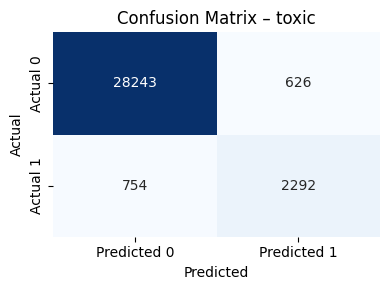

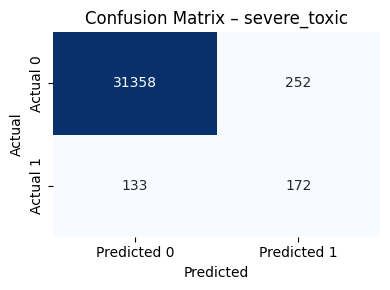

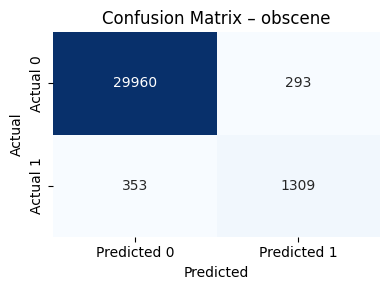

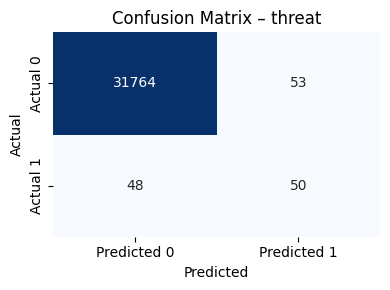

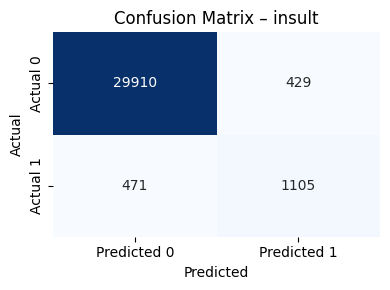

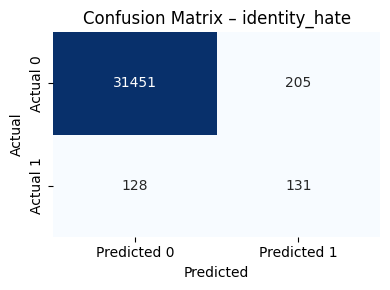

In [ ]:
for label, cm in conf_matrices.items():
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar=False,
        xticklabels=['Predicted 0', 'Predicted 1'],
        yticklabels=['Actual 0', 'Actual 1']
    )
    plt.title(f'Confusion Matrix – {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


# 7- test a new comment

In [ ]:
def classify_new_comment(
    comment,
    tfidf,
    models,
    labels,
    thresholds
):
    clean_comment = str(comment).strip().lower()
    X = tfidf.transform([clean_comment])
    results = {}
    for i, label in enumerate(labels):
        prob = models[label].predict_proba(X)[0, 1]
        pred = int(prob >= thresholds[i])

        results[label] = {
            "probability": round(prob, 4),
            "prediction": pred
        }

    return results


In [ ]:
test_comment = "You are very annoying and rude"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.976 | Pred: 1
severe_toxic    → Prob: 0.006 | Pred: 0
obscene         → Prob: 0.313 | Pred: 0
threat          → Prob: 0.001 | Pred: 0
insult          → Prob: 0.148 | Pred: 0
identity_hate   → Prob: 0.107 | Pred: 0


In [ ]:
test_comment = "kill yourself"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.999 | Pred: 1
severe_toxic    → Prob: 0.414 | Pred: 0
obscene         → Prob: 0.481 | Pred: 0
threat          → Prob: 1.000 | Pred: 1
insult          → Prob: 0.663 | Pred: 0
identity_hate   → Prob: 0.081 | Pred: 0


In [ ]:
test_comment = "very informative"

output = classify_new_comment(
    comment=test_comment,
    tfidf=tfidf,
    models=models,
    labels=labels,
    thresholds=best_thresholds
)

for label, result in output.items():
    print(f"{label:15s} → Prob: {result['probability']:.3f} | Pred: {result['prediction']}")


toxic           → Prob: 0.012 | Pred: 0
severe_toxic    → Prob: 0.009 | Pred: 0
obscene         → Prob: 0.009 | Pred: 0
threat          → Prob: 0.001 | Pred: 0
insult          → Prob: 0.005 | Pred: 0
identity_hate   → Prob: 0.019 | Pred: 0
